# ****

---

## **Overview**

This project analyzes census data in an attempt to predict household earnings.  The original dataset was downloaded from [1994 Census Data](https://archive.ics.uci.edu/ml/datasets/Census+Income) which contains data from the 1994 census.  The dataset contains 48k instances with 14 variables. The data was placed into a public folder in DropBox and can be accessed [here](https://www.dropbox.com/s/qhwnpwn2jka2b3z/adult.data?dl=1)



The general approach to the analysis was:

* Clean up data by identifying and correcting missing values and outliers.
* Look for correlations and trends in the data
* Convert columns with object type to numberic type
* Running multiple  MLP models to train neural networks to classify people as earning more or less than $50k/year

## **Dataset Key Points**
* There are 2399 rows that have 'missing' data (denoted by ? in a field value) that were dropped.
* The following colums appear to have the highest correlation to income:
  - age
  - education-num
  - relationship
  - hours-per-week

## **Results**

The results of analyzing the census data and training models to predict household earnings are presented below.

**From Homework Assignment #2:**
```
You should tune the following parameters:
 * hidden layer sizes
 * activation function
 * maximum number of iterations 
 * learning rate

You should try at least 5 combination of above parameters and report training and test accuracies for each.
Report your results in a tabular format, with a column indicating the parameters used, a column for training accuracy, and one for test accuracy.
```

Multiple MLP models were using various combinations of the tuning parameters specified in the homework assignment.  The results are in the following table.

|  Run # |  Hidden Nodes | Activation Function  | Learning Rate  | Maximum Iterations  | Training Accuracy | Test Accuracy |
|---|---|---|---|---|---|---|
|  #1 |  4,5,4       | logistic | 0.0001  | 500  | 0.85 | 0.85 |
|  #2 |  40,50,40,10 | tanh     | 0.01    | 250  | 0.90 | 0.84 |
|  #3 |  30,20,10    | relu     | 0.01    | 1000 | 0.89 | 0.84 |
|  #4 |  50,25       | relu     | 0.001   | 500  | 0.93 | 0.82 |
|  #5 |  3,4,2       | logistic | 1.1     | 2000 | 0.75 | 0.75 |

**accuracy is the f1 accuracy score retrieved from the metrics.classification_report()**


In [ ]:
import numpy as np # numerical operations
import matplotlib.pyplot as plt # More traditional
import pandas as pd  # reading in data into tabular format
from IPython.display import Markdown, display
import seaborn as sns 

%matplotlib inline 

# Functions to format Markdown output
def printmd(string):
    display(Markdown(string))

def printHorizontalRule():
  printmd("---")

# Load 1994 census data 
# Originally downloaded from: "https://archive.ics.uci.edu/ml/datasets/Census+Income"
url = 'https://www.dropbox.com/s/qhwnpwn2jka2b3z/adult.data?dl=1'

incomedata=pd.read_csv(url, sep=",")
df = pd.DataFrame(incomedata)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-lost','hours-per-week','native-country','income']


# Inspect the Dataset

Review the dataset to understand the overall structure and content of the data.

Look at the columns and data types.  Neural networks need numeric input to work so any non-numeric colums will need to be converted to numeric values in some manner.

Look at the ranges of data to look for outliers or bad data.

Overall the data looks relatively clean.  The next section will review fields with missing data, marked with '?'.

In [ ]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-lost       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
# Check the data to see if there are any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education-num   32560 non-null  int64 
 5   marital-status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital-gain    32560 non-null  int64 
 11  capital-lost    32560 non-null  int64 
 12  hours-per-week  32560 non-null  int64 
 13  native-country  32560 non-null  object
 14  income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Income is the dependant variable in this set.  The goal will be to try and categorize based on 
# the discrete values of 'income'.  These values are:
df['income'].value_counts()

 <=50K    24719
 >50K      7841
Name: income, dtype: int64

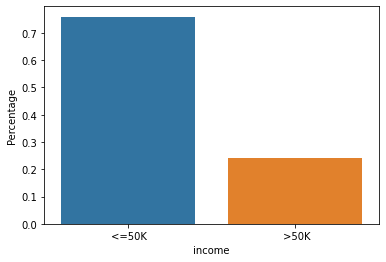

In [ ]:
# It looks like significantly more people make under $50k than make over $50k which may be significant for the model.
chartData = df['income'].value_counts(normalize = True).rename_axis('income').reset_index(name = 'Percentage')
ax = sns.barplot(x = 'income', y = 'Percentage', data = chartData)


In [ ]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-lost,hours-per-week,native-country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K


In [ ]:
# review data ranges of all columns to look for potentially large or small ranges, etc.
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32560,NaN,NaN,NaN,38.5816,13.6406,17,28,37,48,90
workclass,32560,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32560,NaN,NaN,NaN,189782,105550,12285,117832,178363,237054,1.48470e+06
education,32560,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,32560,NaN,NaN,NaN,10.0806,2.57271,1,9,10,12,16
marital-status,32560,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,32560,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32560,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32560,5,White,27815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,32560,2,Male,21789,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean Up Bad or Missing Data
Missing values will have a '?' instead of actual data.  The columns workclass occupation, native-country appear to have missing data.  

The rows containing missing data can either be removed or the missing values can be updated in some way.  Since the fields with missing data are all categories, not numeric, it's not clear what the appropriate category might be so the decision was made to simply remove these records.


In [ ]:
# Remove rows that have hours-per-week over 70, these might be bad data.
df['hours-per-week'].value_counts()
# Drop rows that missing data in workclass
df = df[df['hours-per-week'] < 70]

In [ ]:
# There are 2399 rows that have 'missing' data (denoted by ? in a field value)
def countMissing(dframe, column_name):
  missingdf = dframe[[column_name]]
  missingdf = missingdf[missingdf[column_name].str.contains('\?') == True]
  cnt = len(missingdf.index)
  printmd("**"+ column_name + "** " + str(cnt))

printmd("**Count Rows with Missing Data**")
printHorizontalRule()

# Look at all non-numeric fields.  Numeric fields don't have missing data as ?.
countMissing(df, "workclass")
countMissing(df, "education")
countMissing(df, "marital-status")
countMissing(df, "occupation")
countMissing(df, "relationship")
countMissing(df, "race")
countMissing(df, "sex")
countMissing(df, "native-country")


**Count Rows with Missing Data**

---

**workclass** 1804

**education** 0

**marital-status** 0

**occupation** 1811

**relationship** 0

**race** 0

**sex** 0

**native-country** 562

In [ ]:
# missing 1836 values in workclass column.  These have a value of ?.
printmd("**Workclass Missing Data**")
df['workclass'].value_counts()

**Workclass Missing Data**

 Private             22318
 Self-emp-not-inc     2343
 Local-gov            2049
 ?                    1804
 State-gov            1267
 Self-emp-inc         1024
 Federal-gov           945
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [ ]:
# Drop rows that missing data in workclass
df = df[df['workclass'].str.contains('\?') == False]

In [ ]:
# Look for missing data in occupation column.
printmd("**Occupation Missing Data**")
df['occupation'].value_counts()

**Occupation Missing Data**

 Craft-repair         4030
 Prof-specialty       4017
 Exec-managerial      3940
 Adm-clerical         3751
 Sales                3578
 Other-service        3237
 Machine-op-inspct    1982
 Transport-moving     1513
 Handlers-cleaners    1356
 Tech-support          913
 Farming-fishing       874
 Protective-serv       616
 Priv-house-serv       144
 Armed-Forces            9
 ?                       7
Name: occupation, dtype: int64

In [ ]:
# Drop rows that missing data in occupation
df = df[df['occupation'].str.contains('\?') == False]

In [ ]:
#missing 556 values in native-country after dropping rows above
printmd("**native-country Missing Data**")
df['native-country'].value_counts()

**native-country Missing Data**

 United-States                 26834
 Mexico                          590
 ?                               535
 Philippines                     184
 Germany                         124
 Puerto-Rico                     107
 Canada                          104
 El-Salvador                     100
 India                            97
 Cuba                             91
 England                          83
 Jamaica                          79
 China                            68
 South                            66
 Italy                            64
 Guatemala                        63
 Vietnam                          63
 Dominican-Republic               63
 Japan                            57
 Poland                           56
 Columbia                         56
 Haiti                            41
 Iran                             41
 Taiwan                           40
 Nicaragua                        33
 Portugal                         33
 Peru                             30
 

In [ ]:
# Drop rows that missing data in native-country
df = df[df['native-country'].str.contains('\?') == False]

In [ ]:
# education-num and education are essentially the same thing.  Drop 'education-num' in favor of education so that the education numbers to provide skewed weights.
# The discrete values of 'education' will be converted to boolean valued columns using LabelBinarizer, below
df = df.drop(['education-num'], axis=1)

# Correlations

Look for coorelations between the various features in the dataset relating to income.

The following colums appear to have the highest correlation to income:
* age
* education-num
* relationship
* hours-per-week

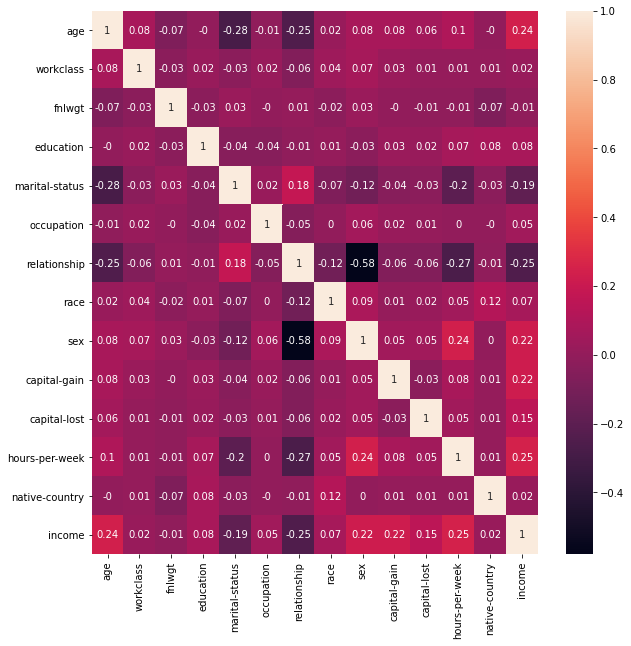

In [ ]:
# Look at correlations
# Visualize column correlations
import seaborn as sns  # New and easy format plot library
from sklearn.preprocessing import LabelEncoder

heatdf = df.copy()

# Convert lables to numeric values to look for correlations
le = LabelEncoder()
for i in range(0, heatdf.shape[1]):
  if heatdf.dtypes[i] == 'object':
    heatdf[heatdf.columns[i]] = le.fit_transform(heatdf[heatdf.columns[i]])

fig, ax = plt.subplots(figsize=(10,10))        
sns.heatmap(data=heatdf.corr().round(2), annot=True)

In [ ]:
# Remove fields that do not have reasonable correlation
# Note: Decided not to remove any columns because the goal of the homework exercise isn't to attempt to get the highest
# accuracy possible.  The goal is to see how the accuracy changes by varying the hyperparameters of a MLPClassifier 
# df = df.drop(['workclass'], axis=1)
# df = df.drop(['fnlwgt'], axis=1)
# df = df.drop(['education'], axis=1)
# df = df.drop(['occupation'], axis=1)
# df = df.drop(['native-country'], axis=1)
# df = df.drop(['race'], axis=1)
# df = df.drop(['relationship'], axis=1)
# df = df.drop(['marital-status'], axis=1)

# Convert column types
Several columns are strings that represent a set of discrete values.  These values need to be converted to a format suitable for consumption by a neural network so they need to be numeric.  

A label encoder could be used to convert each label to a numeric value.  This would be suitable for a decision tree but for a neural network you want values for each feature that contribute in a meaningful way to the weights and output.   Simply converting each value to a magic number would give more weight to the output of the network for some countries than others which might effect the results.

A **LabelBinarizer** will convert each label of a column to a binary column.  This way a label either contributes to the output of the if it's present or will not contribute if it's not present.  All labels, however, will now have an equal impact.

## Columns to Convert

The following columns are of an 'object' type and contain string labels.  This section will convert each discrete value for each of these columns into a separate feature of the dataset.

_**Column**_           
*  workclass         
*  education         
*  marital-status    
*  occupation        
*  relationship      
*  race              
*  sex               
*  native-country            


In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Convert object column labels to columns

def label_binarizer(column_name, dframe):

  if not column_name in dframe:
    return dframe

  lb = LabelBinarizer()
  dframe = dframe.join(pd.DataFrame(lb.fit_transform(df[column_name]),
                                    columns=lb.classes_, 
                                    index=dframe.index), 
                          lsuffix='_' + column_name, 
                          rsuffix='_' + column_name)

  printmd("**`" + column_name + "`** values converted to columns")
  return dframe.drop(columns=[column_name])

df = label_binarizer("workclass", df)
df = label_binarizer("education", df)
df = label_binarizer("marital-status", df)
df = label_binarizer("occupation", df)
df = label_binarizer("relationship", df)
df = label_binarizer("race", df)
df = label_binarizer("native-country", df)

# Convert 'sex' using get_dummies because it fails when using the LabelBinarizer.  Not sure why.
df = pd.get_dummies(df, columns=['sex'])

print()
df.head()

**`workclass`** values converted to columns

**`education`** values converted to columns

**`marital-status`** values converted to columns

**`occupation`** values converted to columns

**`relationship`** values converted to columns

**`race`** values converted to columns

**`native-country`** values converted to columns

,age,fnlwgt,capital-gain,capital-lost,hours-per-week,income,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,...,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-US(Guam-USVI-etc),Peru,Philippines,Poland,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,sex_ Female,sex_ Male
0,50,83311,0,0,13,<=50K,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,38,215646,0,0,40,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,53,234721,0,0,40,<=50K,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,28,338409,0,0,40,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,37,284582,0,0,40,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
df.dtypes

age               int64
fnlwgt            int64
capital-gain      int64
capital-lost      int64
hours-per-week    int64
                  ...  
 United-States    int64
 Vietnam          int64
 Yugoslavia       int64
sex_ Female       uint8
sex_ Male         uint8
Length: 104, dtype: object

# Prepare Training and Test Data

Separate the input data into a set of independent variables (**X**) and the dependend variable (**Y**).  **X** = the set of all columns except 'income'.  **Y** = the set of 'income' values.

All values will be scaled using the sklearn **StandardScaler** to ensure that features with large numeric values do not dominate the model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# X = independent variables (all columns except 'income')
X = df.drop(['income'], axis=1)

# Y = dependent variable: 'income'
Y = df['income'] 

# Split data into test and training data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.20,random_state=1)

# Scale data values
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Create Neural Networks

Train neural networks to classify people as earning more or less than $50k/year.


## Combinations of Hyperparameters

Multiple MLP models were created using the parameters Hidden Nodes, Activation Function,Learning Rate,	Max Iterations.

From Homework Assignment #2:

You should tune the following parameters:
 * hidden layer sizes
 * activation function
 * maximum number of iterations 
 * learning rate

You should try at least 5 combination of above parameters and report training and test accuracies for each.
Report your results in a tabular format, with a column indicating the parameters used, a column for training accuracy, and one for test accuracy.


|  Run # |  Hidden Nodes | Activation Function  | Learning Rate  | Maximum Iterations  | Training Accuracy | Test Accuracy |
|---|---|---|---|---|---|---|
|  #1 |  4,5,4       | logistic | 0.0001  | 500  | 0.85 | 0.85 |
|  #2 |  40,50,40,10 | tanh     | 0.01    | 250  | 0.90 | 0.84 |
|  #3 |  30,20,10    | relu     | 0.01    | 1000 | 0.89 | 0.84 |
|  #4 |  50,25       | relu     | 0.001   | 500  | 0.93 | 0.82 |
|  #5 |  3,4,2       | logistic | 1.1     | 2000 | 0.75 | 0.75 |

**accuracy is the f1 accuracy score retrieved from the metrics.classification_report()**



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score

def mlpfit(title, model, X_train, X_test, Y_train, Y_test):
  printmd("# " + title)
  printHorizontalRule()
  mlp.fit(X_train,Y_train)
  predictions_train = mlp.predict(X_train)
  predictions_test = mlp.predict(X_test)

  printmd("## Confusion Matrix: Training data")
  print(confusion_matrix(Y_train,predictions_train))

  printHorizontalRule()

  printmd("## Classification Report: Training data")
  print(classification_report(Y_train,predictions_train, zero_division=0))

  printmd("## Confusion Matrix: Testing data")
  print(confusion_matrix(Y_test,predictions_test))

  printHorizontalRule()

  printmd("## Classification Report: Testing data")
  print(classification_report(Y_test,predictions_test, zero_division=0))


In [ ]:
# 1st run, 30s to complete
mlp = MLPClassifier(activation='logistic',
                    learning_rate_init=0.0001,
                    hidden_layer_sizes=(4,5,4),
                    learning_rate='constant',
                    max_iter=500, 
                    random_state=5)

mlpfit("Run #1: activation=logistic, lr=0.0001, layers=(4,5,4), iterations=500", mlp, X_train, X_test, Y_train, Y_test)


# Run #1: activation=logistic, lr=0.0001, layers=(4,5,4), iterations=500

---

## Confusion Matrix: Training data

[[16139  1622]
 [ 1881  3898]]


---

## Classification Report: Training data

              precision    recall  f1-score   support

       <=50K       0.90      0.91      0.90     17761
        >50K       0.71      0.67      0.69      5779

    accuracy                           0.85     23540
   macro avg       0.80      0.79      0.80     23540
weighted avg       0.85      0.85      0.85     23540



## Confusion Matrix: Testing data

[[4006  415]
 [ 475  989]]


---

## Classification Report: Testing data

              precision    recall  f1-score   support

       <=50K       0.89      0.91      0.90      4421
        >50K       0.70      0.68      0.69      1464

    accuracy                           0.85      5885
   macro avg       0.80      0.79      0.79      5885
weighted avg       0.85      0.85      0.85      5885



In [ ]:
# 2nd run, 41s
mlp = MLPClassifier(activation='tanh', 
                    learning_rate_init=0.01, 
                    hidden_layer_sizes=(40,50,40,10),
                    max_iter=250, 
                    random_state=5)
mlpfit("Run #2: activation=tanh, lr=0.01, layers=(40,50,40,10), iterations=250",mlp, X_train, X_test, Y_train, Y_test)

# Run #2: activation=tanh, lr=0.01, layers=(40,50,40,10), iterations=250

---

## Confusion Matrix: Training data

[[16888   873]
 [ 1557  4222]]


---

## Classification Report: Training data

              precision    recall  f1-score   support

       <=50K       0.92      0.95      0.93     17761
        >50K       0.83      0.73      0.78      5779

    accuracy                           0.90     23540
   macro avg       0.87      0.84      0.85     23540
weighted avg       0.89      0.90      0.89     23540



## Confusion Matrix: Testing data

[[4052  369]
 [ 579  885]]


---

## Classification Report: Testing data

              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90      4421
        >50K       0.71      0.60      0.65      1464

    accuracy                           0.84      5885
   macro avg       0.79      0.76      0.77      5885
weighted avg       0.83      0.84      0.83      5885



In [ ]:
# 3rd run, 18s to complete
mlp = MLPClassifier(activation='relu', 
                    learning_rate_init=0.01, 
                    hidden_layer_sizes=(30,20,10),
                    max_iter=1000, 
                    random_state=5)
mlpfit("Run #3: activation=relu, lr=0.01, layers=(30,20,10), iterations=1000",mlp, X_train, X_test, Y_train, Y_test)

# Run #3: activation=relu, lr=0.01, layers=(30,20,10), iterations=1000

---

In [ ]:
# 4th run: 1:13 runtime
mlp = MLPClassifier(activation='relu', 
                    learning_rate_init=0.001, 
                    hidden_layer_sizes=(50, 25),
                    max_iter=500, 
                    random_state=5)
mlpfit("Run #4: activation=relu, lr=0.001, layers=(50,25), iterations=500",mlp, X_train, X_test, Y_train, Y_test)


In [ ]:
# 5th run: 1s
mlp = MLPClassifier(activation='logistic', 
                    learning_rate_init=1.1, 
                    hidden_layer_sizes=(3, 4, 2),
                    max_iter=2000, 
                    random_state=5)
mlpfit("Run #5: activation=logistic, lr=1.1, layers=(3,4,2), iterations=2000",mlp, X_train, X_test, Y_train, Y_test)
